
# 📊 Cryptocurrency Price Analysis with Storytelling



## 🔄 Data Collection via CoinCommon adn CoinGecko API

We fetch historical data for 200 cryptocurrency using CoinCompare Api and CoinGecko API for the past 30 days starting from Aug 7th 2025. The fields include:

- Coin
- Price (USD)
- Market Cap
- Volume
- Circulating Supply
- Timestamp
- high
- low
- open
- coingecko id


In [32]:
import requests
import pandas as pd
import time
from tqdm import tqdm

# 🔑 Add your CryptoCompare API Key
CRYPTOCOMPARE_API_KEY = '6a0c8d6eae56e53c0fac03c0bcd15dbb3025463f03e27a0e37bc285e145197f1'

# Endpoints
COINGECKO_MARKET_URL = "https://api.coingecko.com/api/v3/coins/markets"
CRYPTOCOMPARE_URL = "https://min-api.cryptocompare.com/data/v2/histohour"

# Step 1: Get top 250 coins from CoinGecko
def get_top_250_coins():
    params = {
        'vs_currency': 'usd',
        'order': 'market_cap_desc',
        'per_page': 250,
        'page': 1,
        'sparkline': False
    }
    response = requests.get(COINGECKO_MARKET_URL, params=params)
    response.raise_for_status()
    coins = response.json()
    coin_list = []
    for coin in coins:
        coin_list.append({
            'id': coin['id'],
            'symbol': coin['symbol'].upper(),
            'name': coin['name'],
            'market_cap': coin.get('market_cap'),
            'circulating_supply': coin.get('circulating_supply')
        })
    return pd.DataFrame(coin_list)

# Step 2: Get 30 days (720 hours) of hourly data from CryptoCompare
def get_cryptocompare_data(symbol, target='USD', hours=720):
    params = {
        'fsym': symbol,
        'tsym': target,
        'limit': hours,
        'aggregate': 1,
        'api_key': CRYPTOCOMPARE_API_KEY
    }
    response = requests.get(CRYPTOCOMPARE_URL, params=params)
    if response.status_code != 200:
        return None

    data = response.json()
    if data['Response'] != 'Success':
        return None

    df = pd.DataFrame(data['Data']['Data'])
    df['timestamp'] = pd.to_datetime(df['time'], unit='s')
    df['coin'] = symbol
    df.rename(columns={
        'volumeto': 'volume',
        'close': 'price',
        'high': 'high',
        'low': 'low',
        'open': 'open'
    }, inplace=True)
    return df[['timestamp', 'coin', 'price', 'volume', 'high', 'low', 'open']]

# Step 3: Merge data sources
def main():
    gecko_df = get_top_250_coins()
    print(f"✅ Loaded top {len(gecko_df)} coins from CoinGecko")

    final_data = []

    for _, row in tqdm(gecko_df.iterrows(), total=len(gecko_df), desc="Scraping CryptoCompare"):
        symbol = row['symbol']
        coin_id = row['id']
        market_cap = row['market_cap']
        circ_supply = row['circulating_supply']

        cc_data = get_cryptocompare_data(symbol)
        if cc_data is None:
            print(f"[!] Skipping {symbol} (missing data)")
            continue

        cc_data['market_cap'] = market_cap
        cc_data['circulating_supply'] = circ_supply
        cc_data['coingecko_id'] = coin_id

        final_data.append(cc_data)
        time.sleep(1.2)

    if final_data:
        df_final = pd.concat(final_data, ignore_index=True)
        df_final.to_csv("integrated_crypto_data.csv", index=False)
        print(f"✅ Combined data saved to 'integrated_crypto_data.csv'")
    else:
        print("❌ No data retrieved.")

if __name__ == "__main__":
    main()


✅ Loaded top 250 coins from CoinGecko


Scraping CryptoCompare:   1%|          | 2/250 [00:06<13:08,  3.18s/it]


KeyboardInterrupt: 



## 📥 Load and Preview Dataset

We load the previously scraped data (`inergrated_crypto_data.csv`) and begin initial preprocessing.


In [14]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [15]:
df = pd.read_csv('integrated_crypto_data.csv', parse_dates = ['timestamp'])

print('Loaded dataframe with rows: ' + str(df.shape[0]))
print('Loaded dataframe with columns: ' + str(df.shape[1]))

df.head(5)

Loaded dataframe with rows: 144200
Loaded dataframe with columns: 10


,timestamp,coin,price,volume,high,low,open,market_cap,circulating_supply,coingecko_id
0,2025-07-08 00:00:00,BTC,108305.41,67560170.77,108538.36,108194.43,108277.16,2288648265385,19902853.0,bitcoin
1,2025-07-08 01:00:00,BTC,107699.44,62062550.87,108305.95,107683.74,108305.41,2288648265385,19902853.0,bitcoin
2,2025-07-08 02:00:00,BTC,107776.22,85347030.06,107946.86,107445.04,107699.44,2288648265385,19902853.0,bitcoin
3,2025-07-08 03:00:00,BTC,107910.16,22980054.52,108010.89,107698.32,107776.22,2288648265385,19902853.0,bitcoin
4,2025-07-08 04:00:00,BTC,108033.87,15964979.03,108033.87,107761.77,107910.16,2288648265385,19902853.0,bitcoin


In [16]:
daily_volume = df.resample('D', on='timestamp')['volume'].sum().reset_index()
plt.figure(figsize=(12, 6))

# Plot daily data
sns.lineplot(data=daily_volume, x='date', y='volume', color='#1f77b4')

# Formatting
plt.title('Total Daily Volume Timeline', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.grid(alpha=0.3)
plt.tight_layout()

# Save or show
plt.savefig('volume_timeline.png', dpi=300)
plt.show()

ValueError: Could not interpret value `date` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [25]:
# Prepare output folders
base_out = './outputs'
csv_out = os.path.join(base_out, 'csvs')
plots_out = os.path.join(base_out, 'plots')
question_folders = {
    'intraday_ranges': os.path.join(plots_out, '01_intraday_ranges'),
    'event_impact': os.path.join(plots_out, '02_event_impact'),
    'rolling_volatility': os.path.join(plots_out, '03_rolling_volatility'),
    'volume_vs_volatility': os.path.join(plots_out, '04_volume_vs_volatility'),
    'drawdown_analysis': os.path.join(plots_out, '05_drawdown_analysis')
}

os.makedirs(csv_out, exist_ok = True)
os.makedirs(plots_out, exist_ok = True)
for k, v in question_folders.items():
    os.makedirs(v, exist_ok = True)

print('Created folders at: ' + base_out)
print('CSV output folder: ' + csv_out)
print('Plots root folder: ' + plots_out)

Created folders at: ./outputs
CSV output folder: ./outputs/csvs
Plots root folder: ./outputs/plots



## 🧹 Data Cleaning

Let’s ensure numeric types, handle missing or infinite values, normalizing column names and ensure the dataset is analysis-ready.

In [26]:
# Basic cleaning

# Ensure numeric types
cols_num = ['price', 'volume', 'high', 'low', 'open', 'market_cap', 'circulating_supply']
for c in cols_num:
    df[c] = pd.to_numeric(df[c], errors = 'coerce')

# Drop rows missing critical values
before_rows = df.shape[0]
df = df.dropna(subset = ['timestamp', 'coin', 'price'])
after_rows = df.shape[0]
print('Rows before cleaning:')
print(before_rows)
print('Rows after cleaning:')
print(after_rows)

# Add useful columns
df = df.sort_values('timestamp')
df['hour'] = df['timestamp'].dt.hour

def session_label(hour):
    if hour >= 0 and hour < 8:
        return 'Asian'
    elif hour >= 8 and hour < 16:
        return 'European'
    else:
        return 'US'

df['session'] = df['hour'].apply(session_label)

# hourly range (high - low)
df['hourly_range'] = df['high'] - df['low']

# Normalize column names: use 'price' as close if 'close' missing
if 'close' not in df.columns and 'price' in df.columns:
    df['close'] = df['price']
    print('Mapped price to close column')

Rows before cleaning:
144200
Rows after cleaning:
144200


##  a timeline plot of total volume across dataset

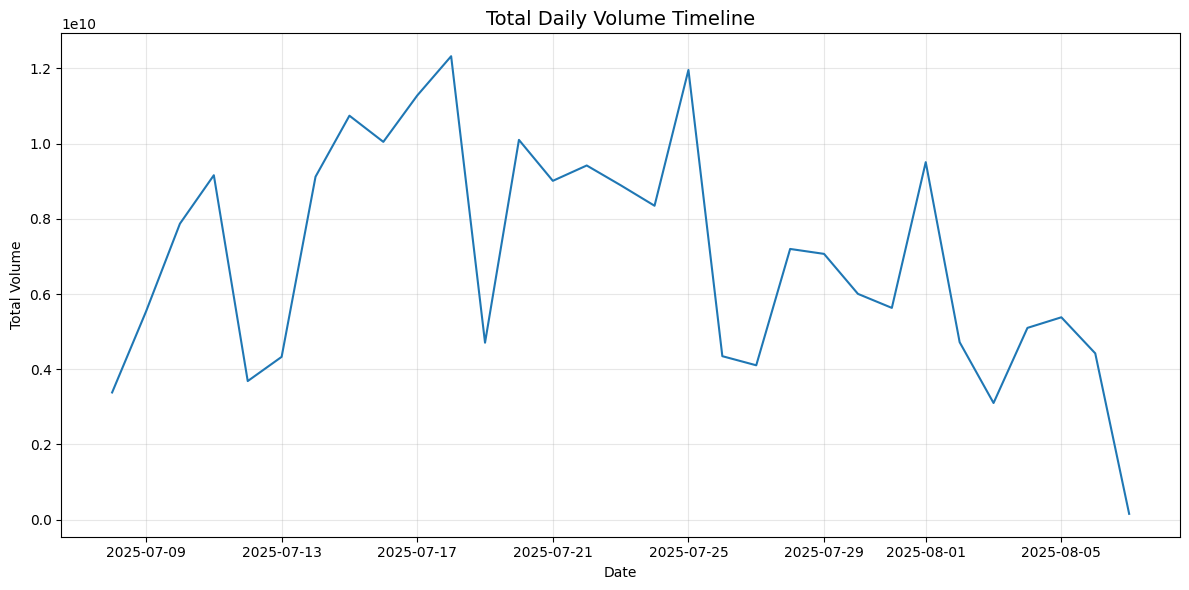

In [18]:
daily_volume = df.resample('D', on='timestamp')['volume'].sum().reset_index()
plt.figure(figsize=(12, 6))

# Plot daily data
sns.lineplot(data=daily_volume, x='timestamp', y='volume', color='#1f77b4')

# Formatting
plt.title('Total Daily Volume Timeline', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Total Volume')
plt.grid(alpha=0.3)
plt.tight_layout()

# Save or show
plt.savefig('volume_timeline.png', dpi=300)
plt.show()


# 📈 Temporal and Volatility Data Analysis

Now we explore Temporal and Volatility analysis across the crptocurrency market begining from 2025-07-08 to 2025-08-07.

## 1. Intraday Pattern Analysis
For each coin, what were the average hourly price ranges (high-low) during Asian (00:00-08:00 UTC), European (08:00-16:00 UTC), and US (16:00-24:00 UTC) trading sessions?

In [27]:
# 1) Average hourly price ranges by coin and hour (intraday ranges)

if 'high' in df.columns and 'low' in df.columns:
    df['hour'] = df['timestamp'].dt.hour
    df['hourly_range'] = df['high'] - df['low']
    avg_ranges = df.groupby(['coin', 'hour'])['hourly_range'].mean().reset_index()
    csv1 = os.path.join(csv_out, 'avg_hourly_ranges_by_coin_hour.csv')
    avg_ranges.to_csv(csv1, index = False)
    print(csv1)
    
    # Save plots for top coins by data count (limit to 20)
    
    top_coins = df['coin'].value_counts().head(20).index.tolist()
    for coin in top_coins:
        sub = avg_ranges[avg_ranges['coin'] == coin]
        plt.figure(figsize = (8,4))
        plt.plot(sub['hour'], sub['hourly_range'], marker = 'o')
        plt.title(coin + ' average hourly range')
        plt.xlabel('hour')
        plt.ylabel('avg hourly range')
        plt.grid(True)
        plotp = os.path.join(question_folders['intraday_ranges'], coin + '_avg_hourly_range.png')
        plt.savefig(plotp, bbox_inches = 'tight')
        plt.close()
        print(plotp)
else:
    print('Missing high/low columns; skipping intraday ranges')

./outputs/csvs/avg_hourly_ranges_by_coin_hour.csv
./outputs/plots/01_intraday_ranges/WETH_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/USDT_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/WBTC_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/DAI_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/DOGE_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/USDC_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/ENS_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/TURBO_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/DRIFT_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/VIRTUAL_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/BTC_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/KAVA_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/LDO_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/S_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/EGLD_avg_hourly_range.png
./outputs/plots/01_intraday_ranges/WI

## 2. Event Impact Assessment: 
Quantify price/volume reactions to major events

In [28]:
if 'close' in df.columns:
    df_sorted = df.sort_values(['coin', 'timestamp']).copy()
    df_sorted['prev_close'] = df_sorted.groupby('coin')['close'].shift(1)
    df_sorted['hourly_ret'] = (df_sorted['close'] - df_sorted['prev_close']) / df_sorted['prev_close']
    df_sorted = df_sorted.replace([np.inf, -np.inf], np.nan).dropna(subset = ['hourly_ret'])
    if not df_sorted['hourly_ret'].empty:
        threshold = df_sorted['hourly_ret'].abs().quantile(0.99)
        events = df_sorted[df_sorted['hourly_ret'].abs() >= threshold].copy()
        csv2 = os.path.join(csv_out, 'event_impact_records_top1pct.csv')
        events.to_csv(csv2, index = False)
        print(csv2)
        
        # save distribution plot with threshold markers
        
        plt.figure(figsize = (8,4))
        sns.histplot(df_sorted['hourly_ret'].dropna(), bins = 100, kde = False)
        plt.axvline(-threshold, color = 'red')
        plt.axvline(threshold, color = 'red')
        plt.title('Hourly returns distribution with top 1% threshold')
        p2 = os.path.join(question_folders['event_impact'], 'hourly_returns_dist_threshold.png')
        plt.savefig(p2, bbox_inches = 'tight')
        plt.close()
        print(p2)
    else:
        print('No hourly returns computed; event impact skipped')
else:
    print('Missing close column; skipping event impact')

./outputs/csvs/event_impact_records_top1pct.csv
./outputs/plots/02_event_impact/hourly_returns_dist_threshold.png


## 3. Rolling Volatility Comparison:
Compare 7-day rolling volatility (standard deviation of daily returns). Which asset showed higher instability?

In [29]:
if 'close' in df.columns:
    
    # Resample to daily close per coin
    df_daily = df.set_index('timestamp').groupby('coin').resample('1D')['close'].last().reset_index()
    df_daily = df_daily.sort_values(['coin', 'timestamp']).reset_index(drop = True)
    df_daily['daily_ret'] = df_daily.groupby('coin')['close'].pct_change()
    
    # 7-day rolling volatility (std of daily returns); min_periods set to 3 to allow early values
  
    df_daily['vol_7d'] = df_daily.groupby('coin')['daily_ret'].rolling(window = 7, min_periods = 3).std().reset_index(level = 0, drop = True)
    csv3 = os.path.join(csv_out, 'rolling_vol_7d_by_coin.csv')
    df_daily.to_csv(csv3, index = False)
    print(csv3)
    
    
    # Plot sample coins (up to 20)
    sample_coins = df_daily['coin'].dropna().unique()[:20]
    for coin in sample_coins:
        s = df_daily[df_daily['coin'] == coin]
        plt.figure(figsize = (10,3))
        plt.plot(s['timestamp'], s['vol_7d'])
        plt.title(coin + ' 7-day rolling volatility')
        plt.xlabel('date')
        plt.ylabel('vol 7d')
        plt.grid(True)
        p3 = os.path.join(question_folders['rolling_volatility'], coin + '_vol7d.png')
        plt.savefig(p3, bbox_inches = 'tight')
        plt.close()
        print(p3)
else:
    print('Missing close column; skipping rolling volatility')

./outputs/csvs/rolling_vol_7d_by_coin.csv
./outputs/plots/03_rolling_volatility/1INCH_vol7d.png
./outputs/plots/03_rolling_volatility/A_vol7d.png
./outputs/plots/03_rolling_volatility/AAVE_vol7d.png
./outputs/plots/03_rolling_volatility/AB_vol7d.png
./outputs/plots/03_rolling_volatility/ADA_vol7d.png
./outputs/plots/03_rolling_volatility/AERO_vol7d.png
./outputs/plots/03_rolling_volatility/AIOZ_vol7d.png
./outputs/plots/03_rolling_volatility/AKT_vol7d.png
./outputs/plots/03_rolling_volatility/ALGO_vol7d.png
./outputs/plots/03_rolling_volatility/AMP_vol7d.png
./outputs/plots/03_rolling_volatility/APE_vol7d.png
./outputs/plots/03_rolling_volatility/APT_vol7d.png
./outputs/plots/03_rolling_volatility/AR_vol7d.png
./outputs/plots/03_rolling_volatility/ARB_vol7d.png
./outputs/plots/03_rolling_volatility/ATH_vol7d.png
./outputs/plots/03_rolling_volatility/ATOM_vol7d.png
./outputs/plots/03_rolling_volatility/AVAX_vol7d.png
./outputs/plots/03_rolling_volatility/AXL_vol7d.png
./outputs/plots/03

## 4. Volume-Volatility Relationship
Is there a statistically significant correlation (Pearson/Spearman) between hourly trading volume and absolute price changes for each coin?

In [31]:
if 'volume' in df.columns:
    if 'hourly_ret' in df_sorted.columns:
        df_sorted = df_sorted.dropna(subset=['hourly_ret', 'volume'])
        df_sorted['abs_hourly_ret'] = df_sorted['hourly_ret'].abs()
        
        corrs = []
        for coin in df_sorted['coin'].unique():
            sub = df_sorted[df_sorted['coin'] == coin]
            if sub['volume'].count() > 10 and sub['abs_hourly_ret'].count() > 10:
                pear = sub['volume'].corr(sub['abs_hourly_ret'])
                spea = sub['volume'].corr(sub['abs_hourly_ret'], method='spearman')
                corrs.append({'coin': coin, 'pearson': pear, 'spearman': spea})
        
        corr_df = pd.DataFrame(corrs)
        csv4 = os.path.join(csv_out, 'volume_volatility_correlation.csv')
        corr_df.to_csv(csv4, index=False)
        print(csv4)
        
        if not corr_df.empty:
            # Existing plot for all coins
            plt.figure(figsize=(14, 6))
            sns.barplot(data=corr_df.sort_values('pearson', ascending=False), 
                        x='coin', y='pearson')
            plt.title('Pearson Correlation: Volume vs Absolute Hourly Returns (All Coins)')
            plt.xticks(rotation=45)
            p4 = os.path.join(question_folders['volume_vs_volatility'], 'volume_vs_volatility_pearson.png')
            plt.savefig(p4, bbox_inches='tight')
            plt.close()
            print(p4)
            
            # NEW: Filter top 10 and bottom 10 coins
            # Sort by Pearson correlation
            sorted_corr = corr_df.sort_values('pearson', ascending=False)
            
            # Get top 10 coins (highest positive correlation)
            top10 = sorted_corr.head(10)
            
            # Get bottom 10 coins (lowest/negative correlation)
            bottom10 = sorted_corr.tail(10)
            
            # Plot for TOP 10 coins
            plt.figure(figsize=(12, 6))
            sns.barplot(data=top10, x='coin', y='pearson', 
                        order=top10.sort_values('pearson', ascending=False)['coin'])
            plt.title('TOP 10: Volume vs Absolute Returns Correlation')
            plt.xticks(rotation=45)
            plt.ylim(top10['pearson'].min() - 0.05, top10['pearson'].max() + 0.05)  # Dynamic y-axis
            p_top = os.path.join(question_folders['volume_vs_volatility'], 'top10_volume_vs_volatility.png')
            plt.savefig(p_top, bbox_inches='tight')
            plt.close()
            print(f"Top 10 plot saved: {p_top}")
            
            # Plot for BOTTOM 10 coins
            plt.figure(figsize=(12, 6))
            sns.barplot(data=bottom10, x='coin', y='pearson', 
                        order=bottom10.sort_values('pearson')['coin'])  # Ascending order
            plt.title('BOTTOM 10: Volume vs Absolute Returns Correlation')
            plt.xticks(rotation=45)
            plt.ylim(bottom10['pearson'].min() - 0.05, bottom10['pearson'].max() + 0.05)
            p_bottom = os.path.join(question_folders['volume_vs_volatility'], 'bottom10_volume_vs_volatility.png')
            plt.savefig(p_bottom, bbox_inches='tight')
            plt.close()
            print(f"Bottom 10 plot saved: {p_bottom}")
    else:
        print('No hourly returns available; skipping volume-volatility')
else:
    print('Missing volume column; skipping volume-volatility')

/home/humpnduati/DATA_SCIENCE/25e---PyData/myenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/humpnduati/DATA_SCIENCE/25e---PyData/myenv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/humpnduati/DATA_SCIENCE/25e---PyData/myenv/lib/python3.13/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


./outputs/csvs/volume_volatility_correlation.csv
./outputs/plots/04_volume_vs_volatility/volume_vs_volatility_pearson.png
Top 10 plot saved: ./outputs/plots/04_volume_vs_volatility/top10_volume_vs_volatility.png
Bottom 10 plot saved: ./outputs/plots/04_volume_vs_volatility/bottom10_volume_vs_volatility.png


## 5.Drawdown Analysis:
Calculate maximum drawdowns:

In [55]:
if 'close' in df.columns:
    # Ensure df_daily exists
    if 'df_daily' not in locals():
        df_daily = df.set_index('timestamp').groupby('coin').resample('1D')['close'].last().reset_index()
        df_daily = df_daily.sort_values(['coin', 'timestamp']).reset_index(drop = True)
    dd_records = []
    for coin in df_daily['coin'].unique():
        s = df_daily[df_daily['coin'] == coin].copy()
        s = s.dropna(subset=['close'])
        if s.empty:
            continue
        s['cum_max'] = s['close'].cummax()
        s['drawdown'] = (s['close'] - s['cum_max']) / s['cum_max']
        if s['drawdown'].isnull().all():
            continue
        idx_min = s['drawdown'].idxmin()
        max_dd = s.loc[idx_min, 'drawdown']
        end_date = s.loc[idx_min, 'timestamp']
        dd_records.append({'coin': coin, 'max_drawdown': max_dd, 'date_of_max_dd': end_date})
    dd_df = pd.DataFrame(dd_records)
    csv5 = os.path.join(csv_out, 'max_drawdowns_by_coin.csv')
    dd_df.to_csv(csv5, index = False)
    print(csv5)
    
    # Plot worst 6 coins by drawdown
    
    if not dd_df.empty:
        worst = dd_df.sort_values('max_drawdown')['coin'].tolist()
        for coin in worst:
            s = df_daily[df_daily['coin'] == coin].copy()
            s = s.dropna(subset = ['close'])
            s['cum_max'] = s['close'].cummax()
            s['drawdown'] = (s['close'] - s['cum_max']) / s['cum_max']
            plt.figure(figsize = (10,3))
            plt.plot(s['timestamp'], s['drawdown'])
            plt.title(coin + ' drawdown over time')
            plt.xlabel('date')
            plt.ylabel('drawdown')
            plt.grid(True)
            p5 = os.path.join(question_folders['drawdown_analysis'], coin + '_drawdown.png')
            plt.savefig(p5, bbox_inches = 'tight')
            plt.close()
            print(p5)
else:
    print('Missing close column; skipping drawdown analysis')

print('Full pipeline completed; all CSVs and plots saved to outputs folder')

./outputs/csvs/max_drawdowns_by_coin.csv
./outputs/plots/05_drawdown_analysis/TKX_drawdown.png
./outputs/plots/05_drawdown_analysis/PUMP_drawdown.png
./outputs/plots/05_drawdown_analysis/FARTCOIN_drawdown.png
./outputs/plots/05_drawdown_analysis/POPCAT_drawdown.png
./outputs/plots/05_drawdown_analysis/VIRTUAL_drawdown.png
./outputs/plots/05_drawdown_analysis/MOG_drawdown.png
./outputs/plots/05_drawdown_analysis/BONK_drawdown.png
./outputs/plots/05_drawdown_analysis/DEEP_drawdown.png
./outputs/plots/05_drawdown_analysis/WEMIX_drawdown.png
./outputs/plots/05_drawdown_analysis/CVX_drawdown.png
./outputs/plots/05_drawdown_analysis/TEL_drawdown.png
./outputs/plots/05_drawdown_analysis/MOVE_drawdown.png
./outputs/plots/05_drawdown_analysis/WLD_drawdown.png
./outputs/plots/05_drawdown_analysis/WIF_drawdown.png
./outputs/plots/05_drawdown_analysis/TURBO_drawdown.png
./outputs/plots/05_drawdown_analysis/FLOKI_drawdown.png
./outputs/plots/05_drawdown_analysis/BEAM_drawdown.png
./outputs/plots/05

In [56]:
# Save cleaned dataframe head for reference
df.head().to_csv('cleaned_data_head.csv', index = False)
print('Saved cleaned_data_head.csv')

print('All analyses completed. Reports and figures saved to current directory.')


Saved cleaned_data_head.csv
All analyses completed. Reports and figures saved to current directory.
